# Unsupervised Learning - Emotion Detection
Apply clustering and dimension reduction algorithms, and see how they may help the Neural Netowrk learner

## Import packages

In [268]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, mean_squared_error, silhouette_score,
    adjusted_rand_score, adjusted_mutual_info_score,
    homogeneity_score, completeness_score, v_measure_score,
)
import time
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.random_projection import GaussianRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from keras.models import Sequential
from keras.layers import AveragePooling2D, Conv2D, Dense, Flatten, Reshape
from keras.utils import to_categorical
import random
from scipy import stats
from statsmodels.stats.stattools import durbin_watson

## Load data

In [2]:
data = pd.read_csv('data/emotion-detection/icml_face_data.csv/icml_face_data.csv')
data = data.rename(columns={' Usage': 'Usage', ' pixels': 'pixels'})  # Somehow column names conatin a leading space

## Set aside a test set

In [320]:
train_set = data[data['Usage']=='Training']
test_set = data[data['Usage']=='PrivateTest']
print(len(train_set), 'train istances +', len(test_set), 'test instances')

28709 train istances + 3589 test instances


## Clean data and normalize features

In [321]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_name].str.strip('"').str.split(pat=' ', expand=True).values

pipeline = Pipeline([
    ('selector', DataFrameSelector('pixels')),
    ('std_scaler', StandardScaler()),
])

train_X = pipeline.fit_transform(train_set)
train_y = np.array(train_set['emotion'])
test_X = pipeline.transform(test_set)
test_y = np.array(test_set['emotion'])

## Re-establish the baseline for neural network learner

In [163]:
neural_netowrk_hyper_parameters = {
    'compiler': {
        'loss': 'categorical_crossentropy',
        'optimizer': 'adam',
        'metrics': ['accuracy'],
    },
    'epochs': 100,
    'batch_size': 1000,
    'verbose': 1,
}

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 120)               276600    
_________________________________________________________________
dense_58 (Dense)             (None, 84)                10164     
_________________________________________________________________
dense_59 (Dense)             (None, 7)                 595       
Total params: 287,359
Trainable params: 287,359
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
29/29 [==============================] - 0s 13ms/step - loss: 1.8151 - accuracy: 0.3016 - val_loss: 1.6583 - val_accuracy: 0.3644
Epoch 2/100
29/29 [==============================] - 0s 8ms/step - loss: 1.5880 - accuracy: 0.3880 - val_loss: 1.6055 - val_accuracy: 0.3901
Epoch 3/100
29/29 [==============================] - 0s 8ms/step - loss: 1.5099 - accuracy: 0.

29/29 [==============================] - 0s 9ms/step - loss: 0.2460 - accuracy: 0.9347 - val_loss: 2.8978 - val_accuracy: 0.4115
Epoch 54/100
29/29 [==============================] - 0s 9ms/step - loss: 0.2368 - accuracy: 0.9364 - val_loss: 2.9537 - val_accuracy: 0.4071
Epoch 55/100
29/29 [==============================] - 0s 8ms/step - loss: 0.2337 - accuracy: 0.9378 - val_loss: 2.9889 - val_accuracy: 0.4040
Epoch 56/100
29/29 [==============================] - 0s 8ms/step - loss: 0.2329 - accuracy: 0.9362 - val_loss: 3.0291 - val_accuracy: 0.4082
Epoch 57/100
29/29 [==============================] - 0s 8ms/step - loss: 0.2259 - accuracy: 0.9383 - val_loss: 3.0389 - val_accuracy: 0.4060
Epoch 58/100
29/29 [==============================] - 0s 8ms/step - loss: 0.1975 - accuracy: 0.9521 - val_loss: 3.0469 - val_accuracy: 0.4090
Epoch 59/100
29/29 [==============================] - 0s 8ms/step - loss: 0.2018 - accuracy: 0.9485 - val_loss: 3.1301 - val_accuracy: 0.4157
Epoch 60/100
29/29 

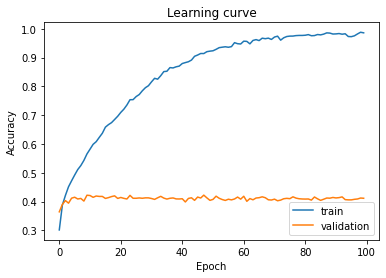

In [165]:
def construct_neural_network_model_0():
    # The famous LeNet-5 neural network with the following adaptation:
    # 1. proper reshaping at the beginning to fit desired input shape
    # 2. last layer of units=7 to fit 7-class classification
    # Codes are adapted from https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086
    clf = Sequential()
    clf.add(Dense(units=120, activation='relu', input_shape=(2304,)))
    clf.add(Dense(units=84, activation='relu'))
    clf.add(Dense(units=7, activation='softmax'))
    clf.compile(**neural_netowrk_hyper_parameters['compiler'])
    clf.summary()
    return clf

def plot_learning_curve(training_history):
    plt.figure(random.randint(0, 10000))
    plt.plot(training_history.history['accuracy'])
    plt.plot(training_history.history['val_accuracy'])
    plt.title('Learning curve')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

def run_neural_netowrk_learner(clf, train_X, train_y, test_X, test_y):
    categorical_train_y = to_categorical(train_y, 7)
    categorical_test_y = to_categorical(test_y, 7)
    training_history = clf.fit(
        train_X, categorical_train_y,
        validation_data=([test_X], [categorical_test_y]),
        epochs=neural_netowrk_hyper_parameters['epochs'],
        batch_size=neural_netowrk_hyper_parameters['batch_size'],
    )
    return training_history
    
clf = construct_neural_network_model_0()
training_history = run_neural_netowrk_learner(clf, train_X, train_y, test_X, test_y)
plot_learning_curve(training_history)

## Part I: Run clustering algorithms

In [322]:
clustering_algorithm = 'em'
assert clustering_algorithm in {'k_means', 'em'}
n_clusters = 26  # Set to an integer (discovered best n_clusters) or a list of integers (to discover best n_clusters)

In [323]:
def constuct_clustering_model(clustering_algorithm, n_clusters):
    if clustering_algorithm == 'k_means':
        clustering_model = KMeans(random_state=0, n_clusters=n_clusters)
    elif clustering_algorithm == 'em':
        clustering_model = GaussianMixture(random_state=0, n_components=n_clusters)
    return clustering_model

def run_clustering_algorithm(clustering_algorithm, n_clusters, train_X):
    if isinstance(n_clusters, int):
        clustering_model = constuct_clustering_model(clustering_algorithm, n_clusters)
        start_time = time.time()
        clustering_model.fit(train_X)
        end_time = time.time()
        print('-----------------------------------------------------------------------')
        print('Result for n_clusters: {}'.format(n_clusters))
        print('Time elapsed (in seconds): {}'.format(end_time - start_time))
        print('Silhouette score: {}'.format(silhouette_score(train_X, clustering_model.predict(train_X), metric='euclidean')))
        if clustering_algorithm == 'k_means':
            print('Sum of squared distances of samples to their closest cluster center: {}'
                  .format(clustering_model.inertia_))
        elif clustering_algorithm == 'em':
            print('AIC: {0}, and BIC: {1}'.format(clustering_model.aic(train_X), clustering_model.bic(train_X)))
    elif isinstance(n_clusters, list):
        sses = []
        aics = []
        bics = []
        silhouette_scores = []
        for n in n_clusters:
            clustering_model = constuct_clustering_model(clustering_algorithm, n)
            start_time = time.time()
            clustering_model.fit(train_X)
            end_time = time.time()
            print('-----------------------------------------------------------------------')
            print('Result for n_clusters: {}'.format(n))
            print('Time elapsed (in seconds): {}'.format(end_time - start_time))
            silhouette = silhouette_score(train_X, clustering_model.predict(train_X), metric='euclidean')
            print('Silhouette score: {}'.format(silhouette))
            silhouette_scores.append(silhouette)
            if clustering_algorithm == 'k_means':
                print('Sum of squared distances of samples to their closest cluster center: {}'
                      .format(clustering_model.inertia_))
                sses.append(clustering_model.inertia_)
            elif clustering_algorithm == 'em':
                aic = clustering_model.aic(train_X)
                bic = clustering_model.bic(train_X)
                print('AIC: {0}, and BIC: {1}'.format(aic, bic))
                aics.append(aic)
                bics.append(bic)
        plt.figure(random.randint(0, 10000))
        plt.plot(n_clusters, silhouette_scores)
        plt.title('Silhouette score v.s. k')
        plt.xlabel('k')
        plt.ylabel('Silhouette score')
        plt.show()
        if clustering_algorithm == 'k_means':
            plt.figure(random.randint(0, 10000))
            plt.plot(n_clusters, sses)
            plt.title('Sum of squared distances of samples to their closest cluster center')
            plt.xlabel('k')
            plt.ylabel('Sum Squared Error')
            plt.show()
        elif clustering_algorithm == 'em':
            plt.figure(random.randint(0, 10000))
            plt.plot(n_clusters, aics, label='AIC')
            plt.plot(n_clusters, bics, label='BIC')
            plt.legend(loc='lower right')
            plt.title('AIC or BIC v.s. k')
            plt.xlabel('k')
            plt.ylabel('AIC or BIC')
            plt.show()
    else:
        raise ValueError('Invalid argument n_clusters: {}. Only int or list of int supported!'.format(n_clusters))
    return clustering_model

In [324]:
def eval_clustering_result(train_y, pred_y):
    print('Adjusted rand score: {}'.format(adjusted_rand_score(train_y, pred_y)))
    print('Adjusted mutual information score: {}'.format(adjusted_mutual_info_score(train_y, pred_y)))
    print('Homogeneity score: {}'.format(homogeneity_score(train_y, pred_y)))
    print('Completeness score: {}'.format(completeness_score(train_y, pred_y)))
    print('V-measure score: {}'.format(v_measure_score(train_y, pred_y)))

In [325]:
def sample_rows(X, y, num_rows_to_sample):
    num_total_rows = X.shape[0]
    random_indices = np.random.choice(num_total_rows, size=num_rows_to_sample, replace=False)
    return X[random_indices, :], y[random_indices]

In [326]:
def viz(X, y):
    # Visulize dimensionality reduction result against true or predicted labels in 2D
    if X.shape[1] > 50:
        X = PCA(n_components=50).fit_transform(X)
    if X.shape[0] > 100:
        X, y = sample_rows(X, y, 100)
    embedded_X = TSNE(random_state=0, n_components=2).fit_transform(X)
    df_tsne = pd.DataFrame(embedded_X, columns=['comp1', 'comp2'])
    df_tsne['label'] = y
    sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

-----------------------------------------------------------------------
Result for n_clusters: 26
Time elapsed (in seconds): 316.6023449897766
Silhouette score: 0.036759050487178764
AIC: -261073818.4931832, and BIC: 310029451.66947967
Adjusted rand score: 0.004347838725571984
Adjusted mutual information score: 0.014754079271702624
Homogeneity score: 0.02200295477910097
Completeness score: 0.012297266227495865
V-measure score: 0.015776935819633242


(array([17,  3, 15, ..., 10,  1, 11]),
 GaussianMixture(n_components=26, random_state=0))

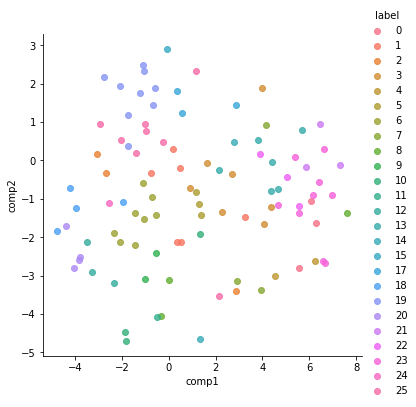

In [327]:
def clustering_all_in_one(clustering_algorithm, n_clusters, train_X, train_y, plot=True):
    # Run clustering algorithm
    clustering_model = run_clustering_algorithm(clustering_algorithm, n_clusters, train_X)
    # Evaluate clustering result against true labels
    pred_y = clustering_model.predict(train_X)
    eval_clustering_result(train_y, pred_y)
    # Visulize clustering result in 2D
    if plot:
        viz(train_X, pred_y)
    return pred_y, clustering_model

clustering_all_in_one(clustering_algorithm, n_clusters, train_X, train_y)

## Part II: Apply dimensionality reduction algorithms

In [308]:
dr_algorithm = 'lda'
assert dr_algorithm in {'pca', 'ica', 'random_projection', 'lda'}
n_components = 6  # For random_projection, set to 'auto'

In [309]:
def construct_dr_model(dr_algorithm, n_components):
    if dr_algorithm == 'pca':
        dr_model = PCA(random_state=0, n_components=n_components)
    elif dr_algorithm == 'ica':
        dr_model = FastICA(random_state=0, n_components=n_components)
    elif dr_algorithm == 'random_projection':
        dr_model = GaussianRandomProjection(random_state=0, n_components=n_components, eps=0.5)
    elif dr_algorithm == 'lda':
        dr_model = LinearDiscriminantAnalysis(n_components=n_components)
    return dr_model

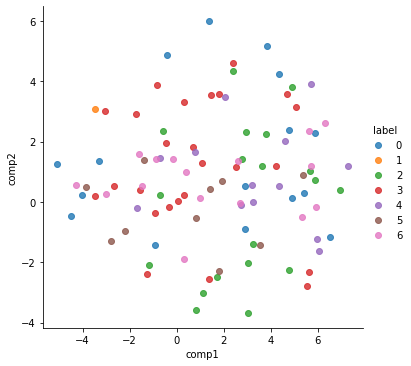

In [315]:
def dr_all_in_one(dr_algorithm, n_components, train_X, train_y):
    # Apply dimensionality reduction algorithm
    dr_model = construct_dr_model(dr_algorithm, n_components)
    reduced_X = dr_model.fit_transform(train_X, train_y)
    # Evaluate MSE between original data and reconstructed data (if possible)
    if dr_algorithm == 'pca' or dr_algorithm == 'ica':
        reconstructed_X = dr_model.inverse_transform(reduced_X)
        print('MSE between original data and reconstructed data: {}'
              .format(mean_squared_error(train_X, reconstructed_X)))
    return reduced_X, dr_model

if n_components is None:
    if dr_algorithm == 'pca':
        _, dr_model = dr_all_in_one(dr_algorithm, n_components, train_X, train_y)
        # Determine n_components that could keep 95% of the variance
        cumsum = np.cumsum(dr_model.explained_variance_ratio_)
        min_n_components = np.argmax(cumsum >= 0.95) + 1
        print('To keep 95% of the variance, reduced dimension needs to be no smaller than {}'
              .format(min_n_components))
    elif dr_algorithm == 'ica':
        ns = list(range(10, 200, 10))
        avg_kurtosis = []
        min_kurtosis = []
        max_kurtosis = []
        avg_dw = []
        min_dw = []
        max_dw = []
        for n in ns:
            reduced_X, _ = dr_all_in_one(dr_algorithm, n, train_X, train_y)
            kurts = np.absolute(stats.kurtosis(reduced_X, fisher=True))
            avg_kurtosis.append(np.mean(kurts))
            min_kurtosis.append(np.min(kurts))
            max_kurtosis.append(np.max(kurts))
            dws = durbin_watson(reduced_X)
            avg_dw.append(np.mean(dws))
            min_dw.append(np.min(dws))
            max_dw.append(np.max(dws))
        plt.figure(random.randint(0, 10000))
        plt.plot(ns, avg_kurtosis, label='Avg Kurtosis')
        plt.plot(ns, min_kurtosis, label='Min Kurtosis')
        plt.plot(ns, max_kurtosis, label='Max Kurtosis')
        plt.xlabel('n_components')
        plt.ylabel('Kurtosis')
        plt.title('Kurtosis v.s. n_components')
        plt.legend(loc='upper left')
        plt.show()
        plt.figure(random.randint(0, 10000))
        plt.plot(ns, avg_dw, label='Avg Durbin-Watson')
        # plt.plot(ns, min_dw, label='Min Durbin-Watson')
        plt.plot(ns, max_dw, label='Max Durbin-Watson')
        plt.xlabel('n_components')
        plt.ylabel('Durbin-Watson')
        plt.title('Durbin-Watson v.s. n_components')
        plt.legend(loc='upper right')
        plt.show()
    elif dr_algorithm == 'lda':
        ns = list(range(2, 7))
        explained_variance_ratios = []
        for n in ns:
            _, dr_model = dr_all_in_one(dr_algorithm, n, train_X, train_y)
            explained_variance_ratios.append(np.sum(dr_model.explained_variance_ratio_))
        plt.figure(random.randint(0, 10000))
        plt.plot(ns, explained_variance_ratios)
        plt.xlabel('n_components')
        plt.ylabel('Explained variance ratio')
        plt.title('Explained variance ratio v.s. n_components')
        plt.show()
else:
    reduced_X, dr_model = dr_all_in_one(dr_algorithm, n_components, train_X, train_y)
    if dr_algorithm == 'random_projection':
        print('To keep the distortion within eps = 0.5, reduced dimension needs to be no smaller than {}'
              .format(dr_model.n_components_))
    viz(reduced_X, train_y)

## Part III: Run clustering algorithm after dimensionality reduction

In [360]:
# Dimensionality reduction settings
dr_algorithm = 'lda'
assert dr_algorithm in {'pca', 'ica', 'random_projection', 'lda'}
n_components = 6

# Clustering settings
clustering_algorithm = 'em'
assert clustering_algorithm in {'k_means', 'em'}
n_clusters = 7  # Set to an integer (discovered best n_clusters) or a list (to discover best n_clusters)

In [361]:
if dr_algorithm == 'lda':
    lda_train_X, lda_test_X, lda_train_y, lda_test_y = train_test_split(
        train_X, train_y, test_size=0.2, random_state=0)
    lda_reduced_train_X, dr_model = dr_all_in_one(dr_algorithm, n_components, lda_train_X, lda_train_y)
    lda_reduced_test_X = dr_model.transform(lda_test_X)
    _, clustering_model = clustering_all_in_one(
        clustering_algorithm, n_clusters, lda_reduced_train_X, lda_train_y, plot=False)
    pred_y = clustering_model.predict(lda_reduced_test_X)
    eval_clustering_result(lda_test_y, pred_y)
else:
    reduced_X, _ = dr_all_in_one(dr_algorithm, n_components, train_X, train_y)
    clustering_all_in_one(clustering_algorithm, n_clusters, reduced_X, train_y)

-----------------------------------------------------------------------
Result for n_clusters: 7
Time elapsed (in seconds): 0.3365919589996338
Silhouette score: 0.06406866766336111
AIC: 409946.56769957626, and BIC: 411514.72136756947
Adjusted rand score: 0.1202290136016507
Adjusted mutual information score: 0.14573791693983837
Homogeneity score: 0.14528010367391067
Completeness score: 0.14695076494454648
V-measure score: 0.14611065878860272
Adjusted rand score: 0.039611179630255455
Adjusted mutual information score: 0.05033373002746151
Homogeneity score: 0.05222836830642388
Completeness score: 0.05173602607971443
V-measure score: 0.05198103140515862


## Part IV: Apply neural network learner after dimensionality reduction

In [372]:
# Dimensionality reduction settings
dr_algorithm = 'lda'
assert dr_algorithm in {'pca', 'ica', 'random_projection', 'lda'}
n_components = 6

# Neural netowrk learner settings
neural_netowrk_hyper_parameters = {
    'compiler': {
        'loss': 'categorical_crossentropy',
        'optimizer': 'adam',
        'metrics': ['accuracy'],
    },
    'epochs': 100,
    'batch_size': 1000,
    'verbose': 1,
}

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 120)               840       
_________________________________________________________________
dense_127 (Dense)            (None, 84)                10164     
_________________________________________________________________
dense_128 (Dense)            (None, 7)                 595       
Total params: 11,599
Trainable params: 11,599
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
29/29 [==============================] - 0s 5ms/step - loss: 1.7169 - accuracy: 0.3681 - val_loss: 1.7188 - val_accuracy: 0.3449
Epoch 2/100
29/29 [==============================] - 0s 2ms/step - loss: 1.4069 - accuracy: 0.4844 - val_loss: 1.8102 - val_accuracy: 0.3394
Epoch 3/100
29/29 [==============================] - 0s 2ms/step - loss: 1.3633 - accuracy: 0.490

29/29 [==============================] - 0s 2ms/step - loss: 1.3220 - accuracy: 0.5012 - val_loss: 1.7981 - val_accuracy: 0.3488
Epoch 54/100
29/29 [==============================] - 0s 2ms/step - loss: 1.3216 - accuracy: 0.5014 - val_loss: 1.8039 - val_accuracy: 0.3527
Epoch 55/100
29/29 [==============================] - 0s 2ms/step - loss: 1.3230 - accuracy: 0.4989 - val_loss: 1.7928 - val_accuracy: 0.3505
Epoch 56/100
29/29 [==============================] - 0s 2ms/step - loss: 1.3224 - accuracy: 0.5007 - val_loss: 1.7973 - val_accuracy: 0.3477
Epoch 57/100
29/29 [==============================] - 0s 2ms/step - loss: 1.3213 - accuracy: 0.5016 - val_loss: 1.7944 - val_accuracy: 0.3522
Epoch 58/100
29/29 [==============================] - 0s 2ms/step - loss: 1.3213 - accuracy: 0.5009 - val_loss: 1.7893 - val_accuracy: 0.3469
Epoch 59/100
29/29 [==============================] - 0s 2ms/step - loss: 1.3223 - accuracy: 0.5007 - val_loss: 1.8002 - val_accuracy: 0.3522
Epoch 60/100
29/29 

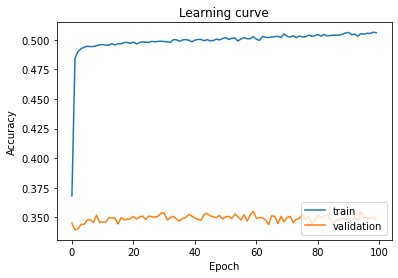

In [373]:
def construct_neural_network_model_1():
    # The famous LeNet-5 neural network with the following adaptation:
    # 1. proper reshaping at the beginning to fit desired input shape
    # 2. last layer of units=7 to fit 7-class classification
    # Codes are adapted from https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086
    clf = Sequential()
    clf.add(Dense(units=120, activation='relu', input_shape=(n_components,)))
    clf.add(Dense(units=84, activation='relu'))
    clf.add(Dense(units=7, activation='softmax'))
    clf.compile(**neural_netowrk_hyper_parameters['compiler'])
    clf.summary()
    return clf

def plot_learning_curve(training_history):
    plt.figure(random.randint(0, 10000))
    plt.plot(training_history.history['accuracy'])
    plt.plot(training_history.history['val_accuracy'])
    plt.title('Learning curve')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

def run_neural_network_learner(clf, train_X, train_y, test_X, test_y):
    categorical_train_y = to_categorical(train_y, 7)
    categorical_test_y = to_categorical(test_y, 7)
    training_history = clf.fit(
        train_X, categorical_train_y,
        validation_data=([test_X], [categorical_test_y]),
        epochs=neural_netowrk_hyper_parameters['epochs'],
        batch_size=neural_netowrk_hyper_parameters['batch_size'],
    )
    return training_history
    
reduced_train_X, dr_model = dr_all_in_one(dr_algorithm, n_components, train_X, train_y)
reduced_test_X = dr_model.transform(test_X)
clf = construct_neural_network_model_1()
training_history = run_neural_network_learner(clf, reduced_train_X, train_y, reduced_test_X, test_y)
plot_learning_curve(training_history)

## Part V: Apply neural network learner after clustering

In [376]:
# Clustering settings
clustering_algorithm = 'em'
assert clustering_algorithm in {'k_means', 'em'}
n_clusters = 26  # Set to an integer (discovered best n_clusters) or a list (to discover best n_clusters)

# Neural netowrk learner settings
neural_netowrk_hyper_parameters = {
    'compiler': {
        'loss': 'categorical_crossentropy',
        'optimizer': 'adam',
        'metrics': ['accuracy'],
    },
    'epochs': 100,
    'batch_size': 1000,
    'verbose': 1,
}

-----------------------------------------------------------------------
Result for n_clusters: 26
Time elapsed (in seconds): 301.0343723297119
Silhouette score: 0.036759050487178764
AIC: -261073818.4931832, and BIC: 310029451.66947967
Adjusted rand score: 0.004347838725571984
Adjusted mutual information score: 0.014754079271702624
Homogeneity score: 0.02200295477910097
Completeness score: 0.012297266227495865
V-measure score: 0.015776935819633242
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 120)               3240      
_________________________________________________________________
dense_133 (Dense)            (None, 84)                10164     
_________________________________________________________________
dense_134 (Dense)            (None, 7)                 595       
Total params: 13,999
Trainable params: 13,999
Non-trainable para

29/29 [==============================] - 0s 2ms/step - loss: 1.7710 - accuracy: 0.2591 - val_loss: 1.8146 - val_accuracy: 0.2480
Epoch 51/100
29/29 [==============================] - 0s 2ms/step - loss: 1.7710 - accuracy: 0.2586 - val_loss: 1.8150 - val_accuracy: 0.2513
Epoch 52/100
29/29 [==============================] - 0s 2ms/step - loss: 1.7713 - accuracy: 0.2598 - val_loss: 1.8154 - val_accuracy: 0.2480
Epoch 53/100
29/29 [==============================] - 0s 2ms/step - loss: 1.7711 - accuracy: 0.2589 - val_loss: 1.8124 - val_accuracy: 0.2513
Epoch 54/100
29/29 [==============================] - 0s 2ms/step - loss: 1.7711 - accuracy: 0.2600 - val_loss: 1.8150 - val_accuracy: 0.2480
Epoch 55/100
29/29 [==============================] - 0s 2ms/step - loss: 1.7709 - accuracy: 0.2584 - val_loss: 1.8176 - val_accuracy: 0.2480
Epoch 56/100
29/29 [==============================] - 0s 2ms/step - loss: 1.7712 - accuracy: 0.2595 - val_loss: 1.8142 - val_accuracy: 0.2513
Epoch 57/100
29/29 

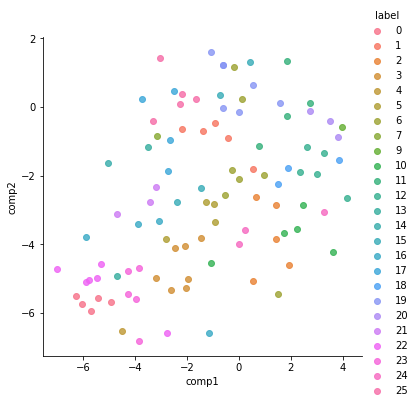

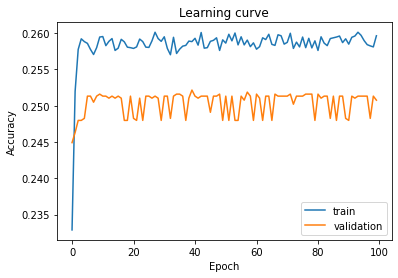

In [377]:
def construct_neural_network_model_2():
    # The famous LeNet-5 neural network with the following adaptation:
    # 1. proper reshaping at the beginning to fit desired input shape
    # 2. last layer of units=7 to fit 7-class classification
    # Codes are adapted from https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086
    clf = Sequential()
    clf.add(Dense(units=120, activation='relu', input_shape=(n_clusters,)))
    clf.add(Dense(units=84, activation='relu'))
    clf.add(Dense(units=7, activation='softmax'))
    clf.compile(**neural_netowrk_hyper_parameters['compiler'])
    clf.summary()
    return clf

train_cluster_labels, clustering_model = clustering_all_in_one(clustering_algorithm, n_clusters, train_X, train_y)
test_cluster_labels = clustering_model.predict(test_X)
one_hot = OneHotEncoder()
one_hot_train_cluster_labels = one_hot.fit_transform(train_cluster_labels.reshape(-1, 1)).todense()
one_hot_test_cluster_labels = one_hot.transform(test_cluster_labels.reshape(-1, 1)).todense()
clf = construct_neural_network_model_2()
training_history = run_neural_network_learner(
    clf, one_hot_train_cluster_labels, train_y, one_hot_test_cluster_labels, test_y)
plot_learning_curve(training_history)

## Find the optimal number of clusters for EM clustering algorithm (AIC v.s. k)

Text(0, 0.5, 'AIC')

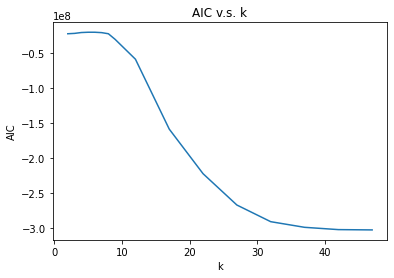

In [31]:
ks = [2, 3, 4, 5, 6, 7, 8, 9, 12, 17, 22, 27, 32, 37, 42, 47]
aics = [
    -22786227, -22268370, -21047018, -20639959, -20645531, -21186225, -22776226, -30798420,
    -59034047, -158605842, -222114231, -266712281, -290427949, -298452091, -301724395, -302160510,
]
plt.plot(ks, aics)
plt.title('AIC v.s. k')
plt.xlabel('k')
plt.ylabel('AIC')